## preprocessing

After some deliberation, we need to perform the following preprocessing steps in service of visualizations:

1. Assign buildings to blocks.
2. Assign blockfaces to blocks.
3. Assign buildings to blockfaces.
4. Assign blockfaces to street segments, with a `{left, right}` relationship.
5. Assign buildings to street frontages.

Assuming we grind through these we will be able to assign litter blame to individual address frontages and up.

In [2]:
import pandas as pd
import geopandas as gpd

buildings = gpd.read_file("../data/SF_Bldg_201610.gdb.zip").to_crs({"init": "epsg:4326"})
streets = gpd.read_file("../data/sf-street-centerlines.geojson")
blocks = gpd.read_file("../data/sf-census-blocks.geojson")

df = pd.read_excel("../data/one-month-data.xlsx")
from shapely.geometry import Point
trash = gpd.GeoDataFrame(df, geometry=df.apply(lambda srs: Point((srs['long'], srs['lat'])), axis='columns'))
del df

In [3]:
pd.set_option('max_columns', None)
buildings.head(3)

,sf16_BldgID,Area_ID,sf_MBLR,P2010mass_Z_MinN88ft,P2010mass_Z_MaxN88ft,gnd_cells50cm,gnd_MINcm,gnd_MAXcm,gnd_RANGEcm,gnd_MEANcm,gnd_STDcm,gnd_VARIETYcm,gnd_MAJORITYcm,gnd_MINORITYcm,gnd_MEDIANcm,cells50cm_1st,MINcm_1st,MAXcm_1st,RANGEcm_1st,MEANcm_1st,STDcm_1st,VARIETYcm_1st,MAJORITYcm_1st,MINORITYcm_1st,MEDIANcm_1st,hgt_cells50cm,hgt_MINcm,hgt_MAXcm,hgt_RANGEcm,hgt_MEANcm,hgt_STDcm,hgt_VARIETYcm,hgt_MAJORITYcm,hgt_MINORITYcm,hgt_MEDIANcm,gnd_Min_m,Median_1st_m,hgt_Median_m,gnd1st_delta_m,peak_1st_m,Shape_Length,Shape_Area,geometry
0,201006.0000001,1,SF4570025,16.3249,66.2671,178250,507,704,197,595.642771,45.538494,191,643,698,600,178250,946,2385,1439,1532.288617,225.942178,1204,1405,946,1416,178250,349,1730,1381,936.644595,210.805564,1206,813,349,850,5.07,14.16,8.50,9.09,23.85,888.193938,44560.769721,(POLYGON Z ((-122.3794906717589 37.73979450665...
1,201006.0000002,2,SM005050270,81.7802,214.1874,144111,2515,3419,904,3015.755862,342.288546,904,2640,3419,3183,144111,2719,6694,3975,4325.526518,1180.055948,3758,4127,2719,3925,144111,11,3872,3861,1309.771794,1031.228898,3808,737,11,735,25.15,39.25,7.35,14.10,66.94,1588.195449,36023.726253,(POLYGON Z ((-122.418929770165 37.707643324529...
2,201006.0000003,3,SF3794028,12.5027,102.5737,115295,164,507,343,397.214164,69.477170,344,380,164,413,115295,322,5918,5596,1922.907750,1213.341180,5180,1106,322,1529,115295,-86,5484,5570,1525.694549,1182.630358,5181,734,-86,1157,1.64,15.29,11.57,13.65,59.18,1568.404996,28821.622762,(POLYGON Z ((-122.3888065511876 37.77923028849...


In [4]:
blocks.head(3)

,statefp10,mtfcc10,uace10,name10,intptlat10,blockce10,awater10,funcstat10,aland10,geoid10,tractce10,intptlon10,ur10,countyfp10,geometry
0,06,G5040,None,Block 2002,+37.7500665,2002,0,S,16958,060750213002002,021300,-122.4410751,None,075,"(POLYGON ((-122.440616 37.750902, -122.440459 ..."
1,06,G5040,None,Block 2000,+37.7501958,2000,0,S,16823,060750213002000,021300,-122.4389330,None,075,"(POLYGON ((-122.438397 37.750226, -122.43832 3..."
2,06,G5040,None,Block 3004,+37.7567937,3004,0,S,17020,060750205003004,020500,-122.4362701,None,075,"(POLYGON ((-122.435808 37.757623, -122.435642 ..."


`sf_MBLR` in `buildings` looks interesting. It's the only identifier in that dataset. The data dictionary says:

> San Francisco property key: Assessor's Map-Block-Lot of land parcel, plus Right-of-way area identifier derived from street Centerline Node Network (CNN)

The right-of-way *may* correspond to a type of easement. From looking at the dataset a right of way, if one is present, is the last digit of the `MBLR`:

In [5]:
buildings['sf_MBLR'].map(lambda v: v[-1]).value_counts()

1    20571
2    16387
0    16328
3    15522
4    15323
5    14984
6    14531
7    14128
8    13680
9    13430
A     9769
B     3888
C     2307
D     1387
E      969
F      705
G      590
H      454
I      326
J      289
K      237
M      192
L      190
N      139
O      126
P      112
Q       95
R       78
S       68
T       55
U       47
V       38
W       27
X       24
Y       16
Z       11
Name: sf_MBLR, dtype: int64

So this ID doesn't look usable for any joins.

Block data is from the 2010 census, e.g. a federal dataset with federal identifiers, and similarly doesn't look useful for any joins.

Streets include a CNN field, which stands for "Street Centerlines and Nodes" and is a labeled graph of city street intersections, as helpfully described [in an online reference](https://datasf.gitbooks.io/draft-publishing-standards/content/basemap/street-centerlines-nodes.html). Again, no real inter-dataset links, which is about what we expected.

## one, assigning buildings to blocks

In [6]:
gpd.sjoin(buildings.head(), blocks, how="left", op='intersects')

,sf16_BldgID,Area_ID,sf_MBLR,P2010mass_Z_MinN88ft,P2010mass_Z_MaxN88ft,gnd_cells50cm,gnd_MINcm,gnd_MAXcm,gnd_RANGEcm,gnd_MEANcm,gnd_STDcm,gnd_VARIETYcm,gnd_MAJORITYcm,gnd_MINORITYcm,gnd_MEDIANcm,cells50cm_1st,MINcm_1st,MAXcm_1st,RANGEcm_1st,MEANcm_1st,STDcm_1st,VARIETYcm_1st,MAJORITYcm_1st,MINORITYcm_1st,MEDIANcm_1st,hgt_cells50cm,hgt_MINcm,hgt_MAXcm,hgt_RANGEcm,hgt_MEANcm,hgt_STDcm,hgt_VARIETYcm,hgt_MAJORITYcm,hgt_MINORITYcm,hgt_MEDIANcm,gnd_Min_m,Median_1st_m,hgt_Median_m,gnd1st_delta_m,peak_1st_m,Shape_Length,Shape_Area,geometry,index_right,statefp10,mtfcc10,uace10,name10,intptlat10,blockce10,awater10,funcstat10,aland10,geoid10,tractce10,intptlon10,ur10,countyfp10
0,201006.0000001,1,SF4570025,16.3249,66.2671,178250,507,704,197,595.642771,45.538494,191,643,698,600,178250,946,2385,1439,1532.288617,225.942178,1204,1405,946,1416,178250,349,1730,1381,936.644595,210.805564,1206,813,349,850,5.07,14.16,8.50,9.09,23.85,888.193938,44560.769721,(POLYGON Z ((-122.3794906717589 37.73979450665...,6307.0,06,G5040,None,Block 1134,+37.7406760,1134,0,S,210383,060759809001134,980900,-122.3809075,None,075
1,201006.0000002,2,SM005050270,81.7802,214.1874,144111,2515,3419,904,3015.755862,342.288546,904,2640,3419,3183,144111,2719,6694,3975,4325.526518,1180.055948,3758,4127,2719,3925,144111,11,3872,3861,1309.771794,1031.228898,3808,737,11,735,25.15,39.25,7.35,14.10,66.94,1588.195449,36023.726253,(POLYGON Z ((-122.418929770165 37.707643324529...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201006.0000003,3,SF3794028,12.5027,102.5737,115295,164,507,343,397.214164,69.477170,344,380,164,413,115295,322,5918,5596,1922.907750,1213.341180,5180,1106,322,1529,115295,-86,5484,5570,1525.694549,1182.630358,5181,734,-86,1157,1.64,15.29,11.57,13.65,59.18,1568.404996,28821.622762,(POLYGON Z ((-122.3888065511876 37.77923028849...,56.0,06,G5040,None,Block 3003,+37.7786612,3003,0,S,19925,060750607003003,060700,-122.3902749,None,075
2,201006.0000003,3,SF3794028,12.5027,102.5737,115295,164,507,343,397.214164,69.477170,344,380,164,413,115295,322,5918,5596,1922.907750,1213.341180,5180,1106,322,1529,115295,-86,5484,5570,1525.694549,1182.630358,5181,734,-86,1157,1.64,15.29,11.57,13.65,59.18,1568.404996,28821.622762,(POLYGON Z ((-122.3888065511876 37.77923028849...,3985.0,06,G5040,None,Block 1001,+37.7798454,1001,0,S,97150,060750607001001,060700,-122.3878069,None,075
2,201006.0000003,3,SF3794028,12.5027,102.5737,115295,164,507,343,397.214164,69.477170,344,380,164,413,115295,322,5918,5596,1922.907750,1213.341180,5180,1106,322,1529,115295,-86,5484,5570,1525.694549,1182.630358,5181,734,-86,1157,1.64,15.29,11.57,13.65,59.18,1568.404996,28821.622762,(POLYGON Z ((-122.3888065511876 37.77923028849...,1112.0,06,G5040,None,Block 3004,+37.7799526,3004,0,S,9394,060750607003004,060700,-122.3886820,None,075
3,201006.0000004,4,SF7295021,NaN,NaN,107634,4346,5185,839,4923.524778,213.559953,840,5100,5185,5031,107634,4954,6972,2018,6119.366538,228.061898,1880,6156,4956,6158,107634,1,2110,2109,1195.842122,286.058540,2054,1078,16,1153,43.46,61.58,11.53,18.12,69.72,1063.512759,26902.836760,(POLYGON Z ((-122.4773367042199 37.72889755971...,4266.0,06,G5040,None,Block 1006,+37.7266983,1006,0,S,50359,060750332011006,033201,-122.4781450,None,075
3,201006.0000004,4,SF7295021,NaN,NaN,107634,4346,5185,839,4923.524778,213.559953,840,5100,5185,5031,107634,4954,6972,2018,6119.366538,228.061898,1880,6156,4956,6158,107634,1,2110,2109,1195.842122,286.058540,2054,1078,16,1153,43.46,61.58,11.53,18.12,69.72,1063.512759,26902.836760,(POLYGON Z ((-122.4773367042199 37.72889755971...,1843.0,06,G5040,None,Block 1011,+37.7269984,1011,0,S,2799,060750332011011,033201,-122.4778673,None,075
3,201006.0000004,4,SF7295021,NaN,NaN,107634,4346,5185,839,4923.524778,213.559953,840,5100,5185,5031,107634,4954,6972,2018,6119.366538,228.061898,1880,6156,4956,6158,107634,1,2110,2109,1195.842122,286.058540,2054,1078,16,1153,43.46,61.58,11.53,18.12,69.72,1063.512759,26902.836760,(POLYGON Z ((-122.4773367042199 37.728

We can get multiple matches to blocks, let's see why.

In [7]:
test_matches = _

In [13]:
%matplotlib inline

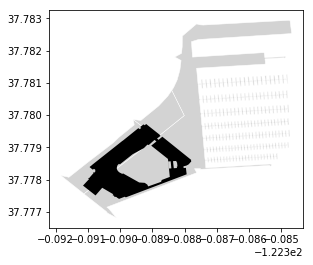

In [51]:
ax = (test_matches
     .query('sf16_BldgID == "201006.0000003"')
     .pipe(lambda df: df.assign(
         block_geometry=df.apply(lambda srs: blocks.iloc[int(srs['index_right'])].geometry, axis='columns'))
     )
     .set_geometry("block_geometry")
     .plot(linewidth=0.5, edgecolor='white', color='lightgray')
)

test_matches.query('sf16_BldgID == "201006.0000003"').head(1).plot(ax=ax, color='black')

Interesting. The unusual shape of the block likely corresponds with a marina. How does this multimatch property generalize to other blocks?

In [54]:
import numpy as np
np.random.seed(42)

test_matches = gpd.sjoin(buildings.sample(1000), blocks, how="left", op='intersects')

In [55]:
len(test_matches)

1010

Only about 1% of building footprints extend across multiple blocks. This may well be due to the changes between the city circa the building footprints dataset snapshot (~2016?), and the census blocks dataset snapshot (2010).

In [77]:
t = (test_matches
         .reset_index(drop=True)
         .groupby("sf16_BldgID")
         .filter(lambda df: True if len(df) > 1 else False))
t

,sf16_BldgID,Area_ID,sf_MBLR,P2010mass_Z_MinN88ft,P2010mass_Z_MaxN88ft,gnd_cells50cm,gnd_MINcm,gnd_MAXcm,gnd_RANGEcm,gnd_MEANcm,gnd_STDcm,gnd_VARIETYcm,gnd_MAJORITYcm,gnd_MINORITYcm,gnd_MEDIANcm,cells50cm_1st,MINcm_1st,MAXcm_1st,RANGEcm_1st,MEANcm_1st,STDcm_1st,VARIETYcm_1st,MAJORITYcm_1st,MINORITYcm_1st,MEDIANcm_1st,hgt_cells50cm,hgt_MINcm,hgt_MAXcm,hgt_RANGEcm,hgt_MEANcm,hgt_STDcm,hgt_VARIETYcm,hgt_MAJORITYcm,hgt_MINORITYcm,hgt_MEDIANcm,gnd_Min_m,Median_1st_m,hgt_Median_m,gnd1st_delta_m,peak_1st_m,Shape_Length,Shape_Area,geometry,index_right,statefp10,mtfcc10,uace10,name10,intptlat10,blockce10,awater10,funcstat10,aland10,geoid10,tractce10,intptlon10,ur10,countyfp10
138,201006.0002722,2722,SF0855053,0.0000,0.0000,4227,1900,2671,771,2400.942749,251.930780,710,2596,1901,2546,4227,2580,4743,2163,4211.568015,236.375531,873,4250,2580,4272,4227,592,2797,2205,1810.624083,349.665964,1326,1703,592,1735,19.00,42.72,17.35,23.72,47.43,194.517865,1056.205564,(POLYGON Z ((-122.42334093485 37.7722385603071...,5863.0,06,G5040,None,Block 1016,+37.7724267,1016,0,S,4236,060750168021016,016802,-122.4235669,None,075
139,201006.0002722,2722,SF0855053,0.0000,0.0000,4227,1900,2671,771,2400.942749,251.930780,710,2596,1901,2546,4227,2580,4743,2163,4211.568015,236.375531,873,4250,2580,4272,4227,592,2797,2205,1810.624083,349.665964,1326,1703,592,1735,19.00,42.72,17.35,23.72,47.43,194.517865,1056.205564,(POLYGON Z ((-122.42334093485 37.7722385603071...,5094.0,06,G5040,None,Block 1015,+37.7727290,1015,0,S,7399,060750168021015,016802,-122.4229060,None,075
314,201006.0011134,11134,SF1939002,337.3702,348.6034,1386,10326,10504,178,10456.779221,36.697217,166,10477,10326,10471,1386,10476,10652,176,10523.922078,40.613847,159,10491,10476,10506,1386,0,278,278,67.150072,59.512102,215,6,77,51,103.26,105.06,0.51,1.80,106.52,66.752790,346.453658,(POLYGON Z ((-122.3657067450564 37.80968542785...,4819.0,06,G5040,None,Block 1060,+37.8105139,1060,0,S,23523,060750179021060,017902,-122.3641813,None,075
315,201006.0011134,11134,SF1939002,337.3702,348.6034,1386,10326,10504,178,10456.779221,36.697217,166,10477,10326,10471,1386,10476,10652,176,10523.922078,40.613847,159,10491,10476,10506,1386,0,278,278,67.150072,59.512102,215,6,77,51,103.26,105.06,0.51,1.80,106.52,66.752790,346.453658,(POLYGON Z ((-122.3657067450564 37.80968542785...,962.0,06,G5040,None,Block 1031,+37.8114200,1031,0,S,68827,060750179021031,017902,-122.3655140,None,075
330,201006.0003336,3336,CN4292008,32.0391,43.1634,3606,985,1104,119,1025.934831,20.404898,116,1017,985,1021,3606,1232,2322,1090,1823.980865,376.568296,694,1349,1232,2023,3606,218,1300,1082,798.041875,372.687006,703,356,218,968,9.85,20.23,9.68,10.38,23.22,146.273623,901.422253,(POLYGON Z ((-122.3910005491485 37.75202643953...,4018.0,06,G5040,None,Block 1010,+37.7519755,1010,0,S,7622,060759809001010,980900,-122.3909277,None,075
331,201006.0003336,3336,CN4292008,32.0391,43.1634,3606,985,1104,119,1025.934831,20.404898,116,1017,985,1021,3606,1232,2322,1090,1823.980865,376.568296,694,1349,1232,2023,3606,218,1300,1082,798.041875,372.687006,703,356,218,968,9.85,20.23,9.68,10.38,23.22,146.273623,901.422253,(POLYGON Z ((-122.3910005491485 37.75202643953...,3951.0,06,G5040,None,Block 1011,+37.7512455,1011,0,S,9582,060759809001011,980900,-122.3915803,None,075
332,201006.0003336,3336,CN4292008,32.0391,43.1634,3606,985,1104,119,1025.934831,20.404898,116,1017,985,1021,3606,1232,2322,1090,1823.980865,376.568296,694,1349,1232,2023,3606,218,1300,1082,798.041875,372.687006,703,356,218,968,9.85,20.23,9.68,10.38,23.22,146.273623,901.422253,(POLYGON Z ((-122.3910005491485 37.75202643953...,577.0,06,G5040,None,Block 1014,+37.7520478,1014,0,S,8938,060759809001014,980900,-122.3920491,None,075
333,201006.0003336,3336,CN4292008,32.0391,43.1634,3606,985,1104,119,1025.934831,20.404898,116,1017,985,1021,3606,1232,2322,1090,1823.980865,376.568296,694,1349,1232,2023,3606,218,1300,1082,798.041875,372.687006,703,356,218,968,9.85,20.23,9.68,10.38,23.22,146.273623,901.422253,(POLYGO

In [84]:
def overplot(test_matches, BldgID):
    ax = (test_matches
     .query(f'sf16_BldgID == "{BldgID}"')
     .pipe(lambda df: df.assign(
         block_geometry=df.apply(lambda srs: blocks.iloc[int(srs['index_right'])].geometry, axis='columns'))
     )
     .set_geometry("block_geometry")
     .plot(linewidth=0.5, edgecolor='white', color='lightgray')
    )

    test_matches.query(f'sf16_BldgID == "{BldgID}"').head(1).plot(ax=ax, color='black')

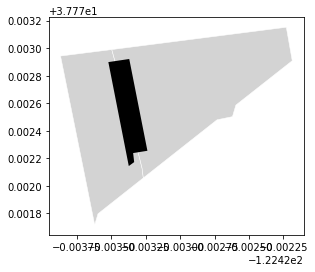

In [85]:
overplot(test_matches, "201006.0002722")

New construction has reshaped these census blocks. This is reflected in the newer building dataset, but not in the older census dataset. [Google Maps link](https://www.google.com/maps/place/37%C2%B046'20.1%22N+122%C2%B025'24.0%22W/@37.7725333,-122.4245846,333m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d37.7722386!4d-122.4233409).

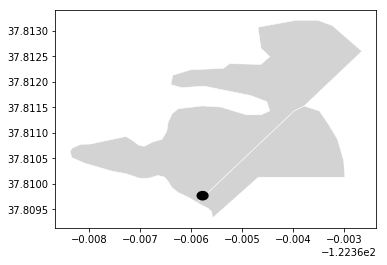

In [87]:
overplot(test_matches, "201006.0011134")

This is the reservoir section of Treasure Island. In fact this object is a water tower over the highway, which passes through a tunnel underneath it. [Google Maps link](https://www.google.com/maps/place/37%C2%B048'34.9%22N+122%C2%B021'56.5%22W/@37.8096894,-122.369951,1333m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d37.8096854!4d-122.3657067).

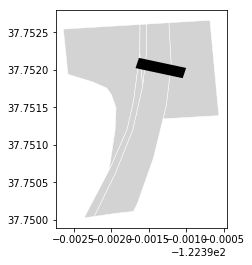

In [88]:
overplot(test_matches, "201006.0003336")

Building underneath an expressway. [Google Maps link](https://www.google.com/maps/place/37%C2%B045'07.3%22N+122%C2%B023'27.6%22W/@37.7520709,-122.3923265,339m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d37.7520264!4d-122.3910005).

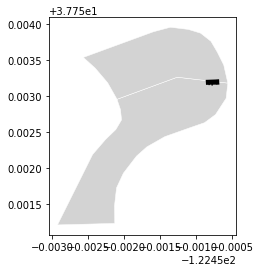

In [89]:
overplot(test_matches, "201006.0075312")

A small home in Forest Knolls. New construction perhaps, because the blocks do not reflect the surrounding geometry almost at all. Skipping the next couple...

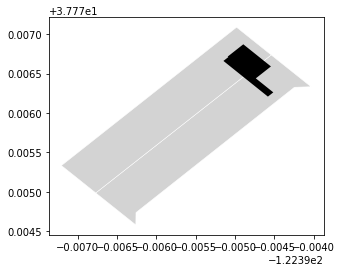

In [90]:
overplot(test_matches, "201006.0001573")

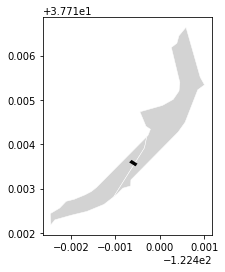

In [91]:
overplot(test_matches, "201006.0096127")

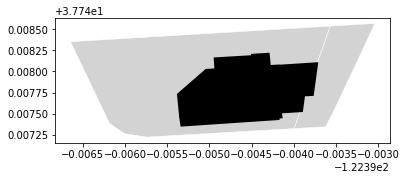

In [92]:
overplot(test_matches, "201006.0000055")

Industrial building with a slightly odd shape that is following a dirt road right beneath a highway. Looks like a census block definition inaccuracy to me. [Google Maps link](https://www.google.com/maps/place/37%C2%B044'50.8%22N+122%C2%B023'39.0%22W/@37.7478958,-122.3948882,342m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d37.7474419!4d-122.3941697).

The incidence rate of failures is low enough that we can remove the offending buildings, with the understanding that this loss of information will cause problems in newly reconstructed sections of the city (like the new medical campuses down in Dogpatch).

In [94]:
%time building_block_matches = gpd.sjoin(buildings, blocks, how="left", op='intersects')

CPU times: user 52.5 s, sys: 1.59 s, total: 54.1 s
Wall time: 55.8 s


In [98]:
len(building_block_matches) - len(buildings)

746

In [102]:
building_block_multimatches = building_block_matches.groupby("sf16_BldgID").filter(lambda df: len(df) > 1)

In [103]:
len(building_block_multimatches)

1444

(37.7, 37.85)

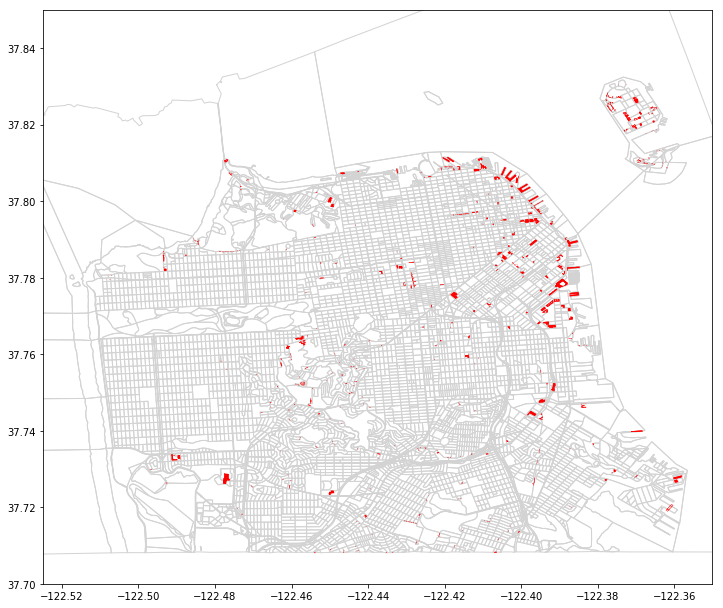

In [114]:
ax = blocks.plot(color='None', linewidth=1, edgecolor='lightgray', figsize=(12,12))
building_block_multimatches.plot(figsize=(12,12), color='red', ax=ax)
ax.set_xlim([-122.525, -122.35])
ax.set_ylim([37.7, 37.85])

There are small join inaccuracies all over the place, but overall the situation looks OK. In some areas you might be forced to define geometries by hand, though, like along the pier.

In [115]:
building_block_matches = building_block_matches.groupby("sf16_BldgID").filter(lambda df: len(df) == 1).reset_index()

There's also problems that go the other way. Some buildings don't get matched to *any* blocks.

In [124]:
building_block_matches.filter?

In [134]:
building_block_misses = building_block_matches[pd.isnull(building_block_matches['index_right'])]

In [135]:
len(building_block_misses)

3141

(37.7, 37.85)

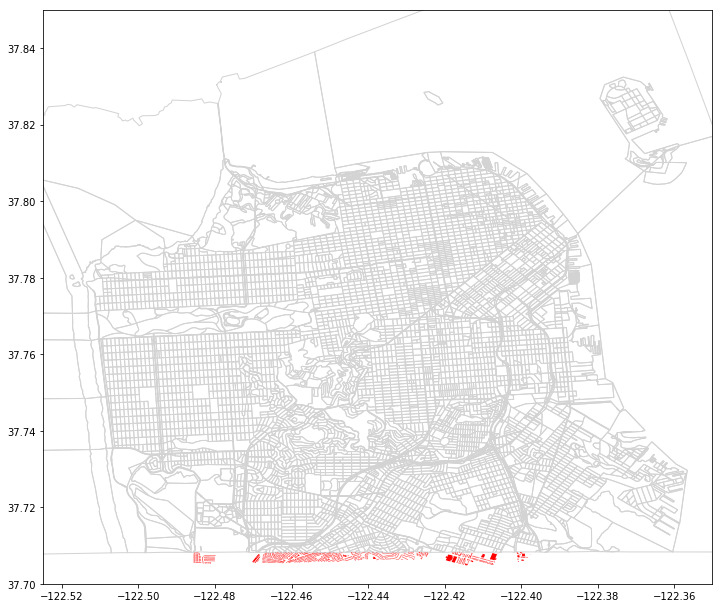

In [140]:
ax = blocks.plot(color='None', linewidth=1, edgecolor='lightgray', figsize=(12,12))
building_block_misses.plot(color='red', ax=ax)
ax.set_xlim([-122.525, -122.35])
ax.set_ylim([37.7, 37.85])

These are all due to the Census aligning the city of San Francisco differently from the city itself, which is interesting in of itself; city boundaries is usually the thing that federal and local sources agree on. Anyway we can drop these.

In [143]:
building_block_matches = building_block_matches[pd.notnull(building_block_matches['index_right'])]

### two, assigning blockfaces to blocks

This is "easy" when the block is a simple square.

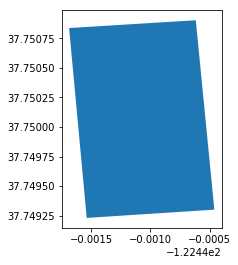

In [145]:
blocks.head(1).plot()

But what do you do when the blocks have complex shapes?

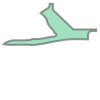

In [154]:
blocks.iloc[45].geometry

Simplifying geomtries shapes within specified tolerances is a difficult geometric problem. You want things like [line simplification algorithms](https://bost.ocks.org/mike/simplify/) to handle it.

In [164]:
blocks.geometry.map(lambda v: type(v)).value_counts()

<class 'shapely.geometry.multipolygon.MultiPolygon'>    7386
Name: geometry, dtype: int64

In [175]:
from shapely.geometry import mapping

In [199]:
len(mapping(blocks.iloc[45].geometry)['coordinates'][0][0])

52

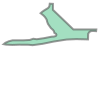

In [207]:
blocks.iloc[45].geometry.simplify(0.000001)

In [202]:
type(blocks.iloc[45].geometry.simplify(0.0002))

shapely.geometry.polygon.Polygon

In [193]:
len(mapping(blocks.iloc[45].geometry.simplify(0.0002))['coordinates'][0])

10

We can assign blockfaces on a simplified shape (which we determine based on a certain maximum mismatch tolerance), then translate those blockfaces to the equivalent segments on the "true" polygons, as the `simplify` routine does not modify points: it only removes them.

In [217]:
blocks.iloc[45].geometry.difference(blocks.iloc[45].geometry.simplify(0.001)).area / blocks.iloc[45].geometry.area

0.5657524905975444

In [218]:
blocks.iloc[45].geometry.difference(blocks.iloc[45].geometry.simplify(0.0001)).area / blocks.iloc[45].geometry.area

0.017031721653597644

In [265]:
def simplify(shp, tol=0.05):
    """
    Generate a simplified shape for shp, within a 5 percent tolerance.
    
    Used for blockface alignment.
    """
    for thresh in [0.001, 0.0005, 0.0004, 0.0003, 0.0002, 0.0001]:
        simp = shp.simplify(thresh)
        if shp.difference(simp).area / shp.area < tol:
            break
    
    return simp

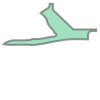

In [258]:
blocks.iloc[45].geometry

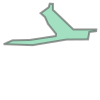

In [259]:
simplify(blocks.iloc[45].geometry)

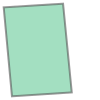

In [260]:
blocks.iloc[0].geometry

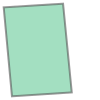

In [261]:
simplify(blocks.iloc[0].geometry)

TODO. To continue from here:

* Fix this error.
* Graph before and after geometric complexities.
* Check radically simplfied transforms results for kinks.
* Map back to line segments in the complex blocks.
* Proceed from there.

In [266]:
from tqdm import tqdm_notebook
simplified_blocks = tqdm_notebook(blocks.geometry.map(lambda g: simplify(g)))

TopologyException: Input geom 0 is invalid: Self-intersection at or near point -122.45601400000001 37.752358999999998 at -122.45601400000001 37.752358999999998


TopologicalError: The operation 'GEOSDifference_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.multipolygon.MultiPolygon object at 0x13a59ebe0>

In [267]:
%debug

> /Users/alex/miniconda3/envs/trash-talk/lib/python3.6/site-packages/shapely/topology.py(38)_check_topology()
     36                     "The operation '%s' could not be performed. "
     37                     "Likely cause is invalidity of the geometry %s" % (
---> 38                         self.fn.__name__, repr(geom)))
     39         raise err
     40 

ipdb> up
> /Users/alex/miniconda3/envs/trash-talk/lib/python3.6/site-packages/shapely/topology.py(70)__call__()
     68             err = TopologicalError(
     69                     "This operation could not be performed. Reason: unknown")
---> 70             self._check_topology(err, this, other)
     71         return product
     72 

ipdb> up
> /Users/alex/miniconda3/envs/trash-talk/lib/python3.6/site-packages/shapely/geometry/base.py(616)difference()
    614     def difference(self, other):
    615         """Returns the difference of the geometries"""
--> 616         return geom_factory(self.impl['difference'](self, other